# Food Segmentation using U-Net

# Loading dataset

*   For this project, I will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.

In [1]:
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np

import os

from tensorflow.keras import layers
from tensorflow.keras.utils import load_img

from skimage.transform import resize
from skimage import io

# Constants

*   Change the path of the directories according to your drive location.

In [2]:
root_path = r'TrayDataset'
train_img = os.path.join(root_path, 'XTrain')
train_mask = os.path.join(root_path, 'yTrain')
test_img = os.path.join(root_path, 'XTest')
test_mask = os.path.join(root_path, 'yTest')

*   Define the constants needed for training the model

In [3]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 25

# Paths to Input Images and Segmentation Masks

*   Prepare the list of images and masks for both the train and test set

In [4]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

To correctly show the different classes of the segmentation, I have created an own cmap that represent each segmented object into one representative color.

In [5]:
from matplotlib import colors
def calc_cmap(labels):
    color_list = ["#000000", "#e6f0ea", "#6e717a", "#c6ccc9", "#91e9ed", "#ed2e11", "#fa4f34", "#c93922",
                  "#a64030", "#db0457", "#24e34a", "#54c782", "#02cc9d", "#f0073a", "#e5e8e3", "#bd1346",
                  "#bce0a4", "#1399a8", "#a17b43", "#30b80f", "#f0a502", "#03a106", "#f7b423", "#04c90e",
                  "#e0e396", "#48bd46", "#dce0dc", "#dee359", "#f3f779", "#ebb954", "#f5f551", "#f5dda9",
                  "#d66c63", "#b54c18", "#ffffff", "#e2f794", "#f5776e", "#d2e691", "#f2fcd2", "#27ff24",
                  "#6ec96d", "#faa961", "#0635c2"]
    max_class = np.max(np.unique(labels))
    return color_list[:max_class+1]

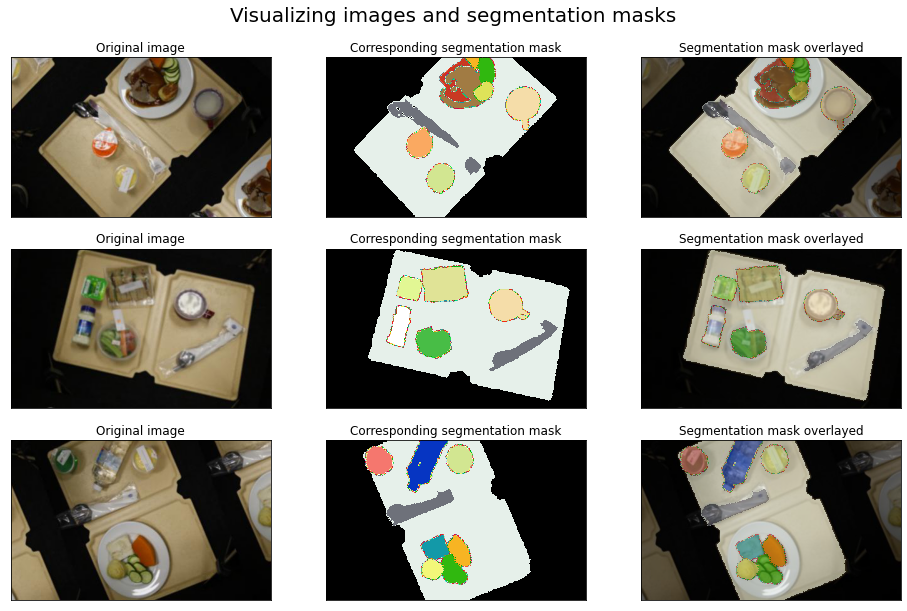

In [7]:
from random import randint

samples = [randint(0,1241) for i in range(3)] # We will visualize three random images
samples = [10, 660, 1000]
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16, 10))
fig.suptitle("Visualizing images and segmentation masks", y=0.95, x=0.51, size=20)

for n, im in enumerate(samples):
  image = io.imread(train_img_paths[im])
  mask = io.imread(train_mask_paths[im], as_gray=True)
  cmap = colors.ListedColormap(calc_cmap(io.imread(train_mask_paths[im])))
  axs[n, 0].imshow(image)
  axs[n, 0].set_title("Original image")
  axs[n, 1].imshow(mask, cmap = cmap)
  axs[n, 1].set_title("Corresponding segmentation mask")
  # Superimposed images
  axs[n, 2].imshow(image)
  axs[n, 2].imshow(mask, cmap = cmap, alpha = 0.5)
  axs[n, 2].set_title("Segmentation mask overlayed")

plt.setp(axs, xticks=[], yticks=[])
plt.show()

# Image Generator

*   Create an image generator class to iterate over the images and return a tuple corresponding to the batch number.

In [6]:
class ImageGenerator(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   Create the U-Net Xception-style architecture using Keras.

In [9]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [10]:
# Free up RAM in case the model definition cells were run multiple times
import keras
keras.backend.clear_session()

In [11]:
# Build model
model = get_model(img_size, num_classes)

*   Print the summary of the model

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

# Instantiate Image Generators for each split

*   For this experiment, I will use the test split as the validation generator

In [13]:
print(f'Number of test images: ', len(test_img_paths))

Number of test images:  8


In [14]:
import random

random.Random(1337).shuffle(train_img_paths)
random.Random(1337).shuffle(train_mask_paths)

# Instantiate data Sequences for each split
train_gen = ImageGenerator(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = ImageGenerator(8, img_size, test_img_paths, test_mask_paths) # batch size = 8 because there are 8 test images (validation generator)

# Train Model

*   Configure the model for training

In [15]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [16]:
callbacks = [keras.callbacks.ModelCheckpoint("traydataset_segmentation.h5", save_best_only=True)]

*   Train the model using fit method

In [17]:
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - 16s 234ms/step - loss: 1.8535 - val_loss: 2.5453
Epoch 2/25
38/38 [==============================] - 8s 204ms/step - loss: 0.6215 - val_loss: 18.6469
Epoch 3/25
38/38 [==============================] - 8s 205ms/step - loss: 0.4595 - val_loss: 15.9767
Epoch 4/25
38/38 [==============================] - 8s 205ms/step - loss: 0.3403 - val_loss: 16.9386
Epoch 5/25
38/38 [==============================] - 8s 204ms/step - loss: 0.2742 - val_loss: 18.7336
Epoch 6/25
38/38 [==============================] - 8s 205ms/step - loss: 0.2340 - val_loss: 15.3262
Epoch 7/25
38/38 [==============================] - 8s 205ms/step - loss: 0.2061 - val_loss: 17.6434
Epoch 8/25
38/38 [==============================] - 8s 205ms/step - loss: 0.1768 - val_loss: 17.8497
Epoch 9/25
38/38 [==============================] - 8s 206ms/step - loss: 0.1599 - val_loss: 14.6830
Epoch 10/25
38/38 [==============================] - 8s 205ms/step - loss: 0.1506 - val_los

In [18]:
def plot_history(history, arch_name, ep, min_loss, max_loss):
  plt.figure(figsize = (10,6))
  plt.title('Cross Entropy Loss using ' +  arch_name, fontsize=14)
  plt.plot(history.history['loss'], color='blue', label='Train')
  plt.plot(history.history['val_loss'], color='red', label='Validation')
  plt.xlabel('Epochs')
  plt.ylim((min_loss, max_loss))
  plt.xlim((0, ep-1))
  plt.ylabel('Cross-entropy loss')
  plt.legend(fontsize=12)

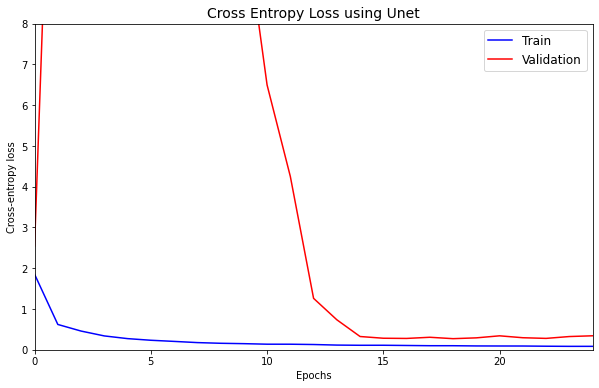

In [19]:
plot_history(history, 'Unet', epochs, 0, 8)

# Visualize predictions

*   Generate predictions for all images in the validation set

In [20]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = ImageGenerator(batch_size, img_size, test_img_paths, test_mask_paths)

In [21]:
# solution
preds = model.predict(val_gen)

8/8 [==============================] - 1s 5ms/step


In [22]:
pred_masks = np.argmax(preds, axis=-1)

In [23]:
from skimage.transform import resize

# Reading the ground truth, resizing to the same values as the one sused in the network (160, 160)
# and converting them to numpy array

test_masks = [np.array(resize(io.imread(file_name, as_gray=True), img_size)*255, dtype = 'uint8') for file_name in test_mask_paths]

*   For each validation image, I find the jaccard similarity score

In [24]:
from sklearn.metrics import jaccard_score
c = 0
for pred, gt in zip(pred_masks, test_masks):
    js = jaccard_score(pred.flatten(), gt.flatten(), average='micro')
    c += 1
    print(f"Jaccard Score for sample {c} is -> {round(js,4)}")

Jaccard Score for sample 1 is -> 0.7796
Jaccard Score for sample 2 is -> 0.8409
Jaccard Score for sample 3 is -> 0.6696
Jaccard Score for sample 4 is -> 0.8737
Jaccard Score for sample 5 is -> 0.7959
Jaccard Score for sample 6 is -> 0.7853
Jaccard Score for sample 7 is -> 0.7661
Jaccard Score for sample 8 is -> 0.8432


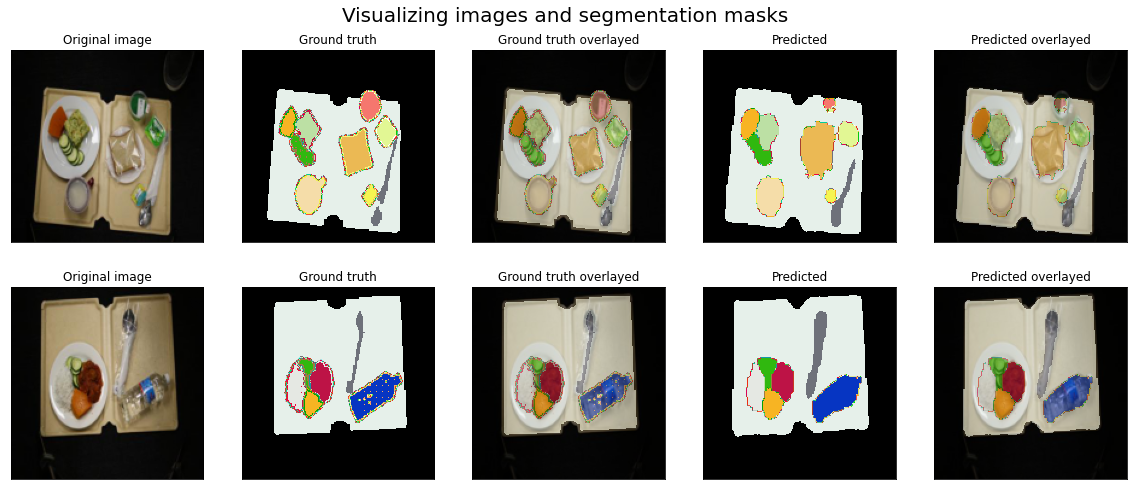

In [32]:
# I have randomly displayed two of the evaluation images
samples = [randint(0,7) for i in range(2)]
samples = [5,3]
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 8))
fig.suptitle("Visualizing images and segmentation masks", y=0.95, x=0.51, size=20)

for n, im in enumerate(samples):
    ima = resize(np.array(load_img(test_img_paths[im])), (160, 160))
    gt = test_masks[im]
    cmap = colors.ListedColormap(calc_cmap(io.imread(test_mask_paths[im])))
    axs[n, 0].imshow(ima)
    axs[n, 0].set_title("Original image")
    # Ground truth image
    axs[n, 1].imshow(gt, cmap = cmap)
    axs[n, 1].set_title("Ground truth")
    axs[n, 2].imshow(ima)
    axs[n, 2].imshow(gt, cmap = cmap, alpha = 0.5)
    axs[n, 2].set_title("Ground truth overlayed")
    # Predicted image
    pred = pred_masks[im]
    cmap = colors.ListedColormap(calc_cmap(pred))
    axs[n, 3].imshow(pred, cmap = cmap)
    axs[n, 3].set_title("Predicted")
    axs[n, 4].imshow(ima)
    axs[n, 4].imshow(pred, cmap = cmap, alpha = 0.5)
    axs[n, 4].set_title("Predicted overlayed")
plt.setp(axs, xticks=[], yticks=[])
plt.show()